# Sentiment Analysis with BERT

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [79]:
!pip install -q -U watermark

In [80]:
!pip install -qq transformers

In [81]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.8
IPython version      : 7.18.1

numpy       : 1.18.5
pandas      : 1.1.3
torch       : 1.4.0
transformers: 3.5.1



In [82]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cpu")
device

device(type='cpu')

## Data Exploration

In [149]:
df = pd.read_csv("all_outputs.csv")
df.head()

,business_id,gold_summ,gen_summ,review1,review2,review3,review4,review5,review6,review7,review8
0,NWh0MGOPFAy7yElepNtIxg,The beauty of this place is that it has high q...,Love this place! I've been here three times no...,chopshop is the greatest versatile spot becaus...,i've recently found this charming new restaura...,poor quality food. steak sandwich with mushroo...,"i love this place, everything tastes good and ...",perfect! real food. quality choices. fast. gre...,loved everything we ordered. we got a beet sal...,great spot. went there tonight for the first t...,had to go out to eat after eating a salad here...
1,Nbhpg1TbDwtMuyh9ZIPceA,This place is a small family owned Thai restau...,This place is fantastic! The food was deliciou...,it was okay but we were expecting more based o...,awesome little thai place! the food is amazing...,this was one random little thai restaurant tha...,i stumbled across this place by accident when ...,"we got the thai fried rice, egg rolls and many...",this place was awful. i ordered tamarind duck ...,"a little scary outside, inside a real gem. fam...",i had panang curry and j had thai spicy noddle...
2,Ohu6w8_RYE5KdHEWGdBjXQ,The Mesa Arts Center is a clean modern place t...,This is the second time I've been here and bot...,went to see our favorite artist last night (gr...,"great place to see some interesting art, but o...",i love the mesa arts center. the concert halls...,my favorite theater in phoenix! relatively new...,"no lie, i'd pay $20 more to see a concert here...",horrible seating very very disappointed at the...,been coming here for years. many shows here an...,mac is a great venue. matthew morrison was kin...
3,OkC86YtZ0Nm19my5F4GGrQ,Tartine is a nice place with a combination of ...,The food here is a little pricey but worth eve...,love the atmosphere of this place. it tends to...,amazing. excellent choice for lunch. baked bri...,we were greeted cordially and given a prime ou...,first time going here and i was impressed. ver...,my fiance and i really enjoyed eating here for...,i'm not sure why i was so hard with my first r...,i am not overwhelmed. been here twice and foun...,"the best combination of atmosphere, food, and ..."
4,Q2ZNaN3p8s_-XXjBWyY2qA,The service at Ruth's steakhouse is serviceabl...,Best meal I've ever had in a long time. The st...,first time at this restaurant. from the greeti...,it is great but compared to other ruth's chris...,hey everyone! ruth's chris steak house is sooo...,the best filet minion in toronto. super smooth...,had a top sirloin steak today with mushroom an...,got the filet with a side of mac and cheese. s...,if you blink you might miss this gem across th...,4 stars for the amazingly soft and tender stea...


In [84]:
#df = df[['business_id','stars','text','sentiment']]
df.tail()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
29995,n7nJzWURyuiUSvzNXpBpVg,kB-0ik8Xtw3kwuN4WM81yQ,hcFSc0OHgZJybnjQBrL_8Q,4.0,0,0,0,"As a noodle fan, it's good to go! The size per...",2017-08-01 20:18:17,positive
29996,FYsXeILs2nbwq2HutkDNyw,3Uv0dGI2IXJb2OUj8R2GJA,eoJfl5vG7X87QhcKb0nt5Q,4.0,5,3,3,This place is the Disneyland of beer.\n\nYou w...,2017-01-12 02:50:34,positive
29997,creE4zCXK7ZS0BihvVV9yg,6_OUuFht6DEC01zTU0bFrw,TEwzpsuLkAM6RZkUSApTHg,5.0,0,0,0,"Jason is a rare breed, an honest mechanic who ...",2017-09-05 21:12:27,positive
29998,5RgrT8LArbmpZ1IedF_K1A,k4aO7Jy00yNbjl3YQ3KI-Q,DWGD9u3zqPTH8w4j5VUVsg,5.0,3,0,1,Dr Chamberlains team is terrific. I could not ...,2015-07-09 12:56:46,positive
29999,0hiC-taLnSZaqF3L-tyvsQ,KLxAVh_8DwgYLR14g-g3oQ,zpGCFAt_MydbQN4EsXee6w,5.0,0,0,1,I had a patient that recommended this place to...,2018-04-18 01:30:11,positive


In [85]:
df.shape

(30000, 10)

#### Check for missing values:

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    30000 non-null  object 
 1   user_id      30000 non-null  object 
 2   business_id  30000 non-null  object 
 3   stars        30000 non-null  float64
 4   useful       30000 non-null  int64  
 5   funny        30000 non-null  int64  
 6   cool         30000 non-null  int64  
 7   text         30000 non-null  object 
 8   date         30000 non-null  object 
 9   sentiment    30000 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 2.3+ MB


In [87]:
#drop NA in 'text'
df = df.dropna(subset=['text'])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    30000 non-null  object 
 1   user_id      30000 non-null  object 
 2   business_id  30000 non-null  object 
 3   stars        30000 non-null  float64
 4   useful       30000 non-null  int64  
 5   funny        30000 non-null  int64  
 6   cool         30000 non-null  int64  
 7   text         30000 non-null  object 
 8   date         30000 non-null  object 
 9   sentiment    30000 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 2.5+ MB


#### Equally sampled 200k from each sentiment to avoid class imbalance
(stars <= 2 is negative; = 3 is neutral; >= 4 is positive)

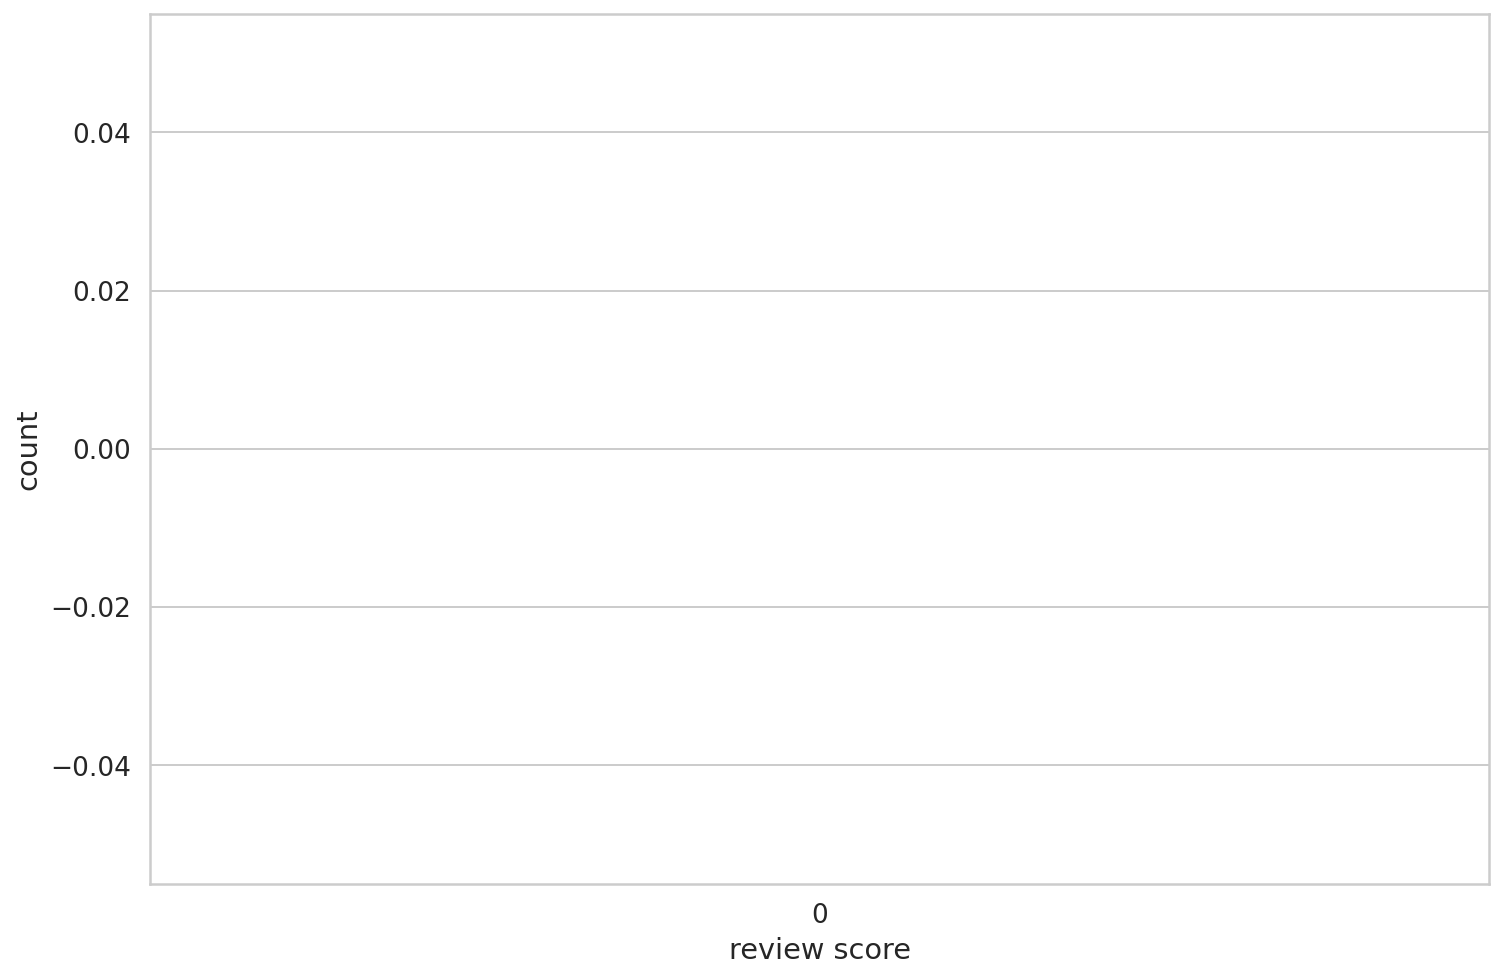

In [89]:
sns.countplot()
plt.xlabel('review score');

In [90]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.stars.apply(to_sentiment)

In [91]:
class_names = ['negative', 'neutral', 'positive']

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


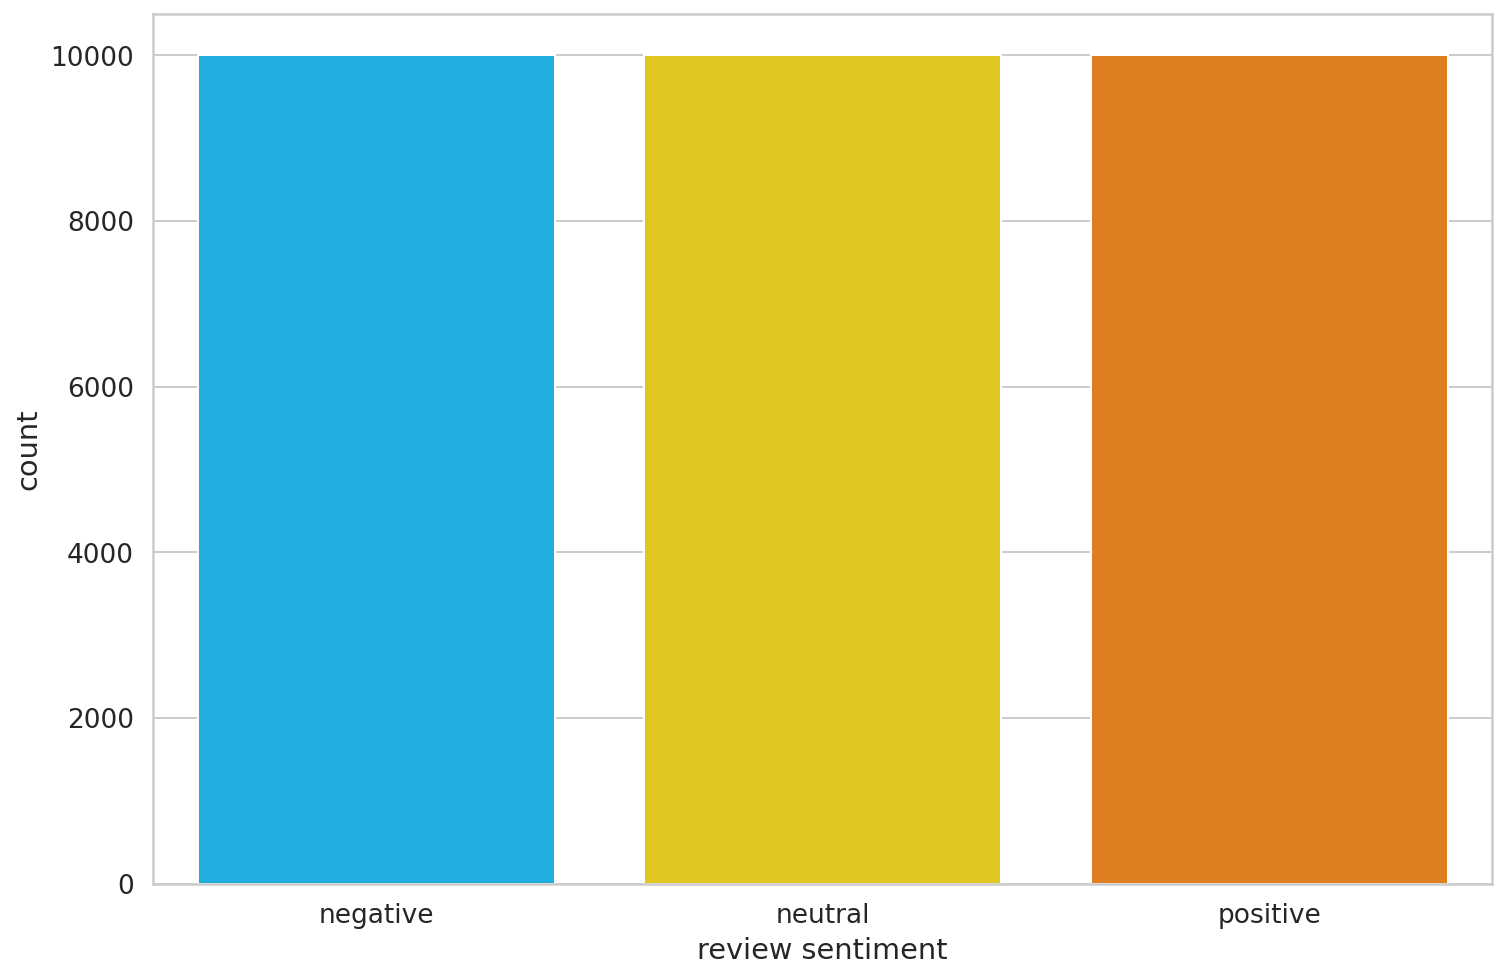

In [92]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

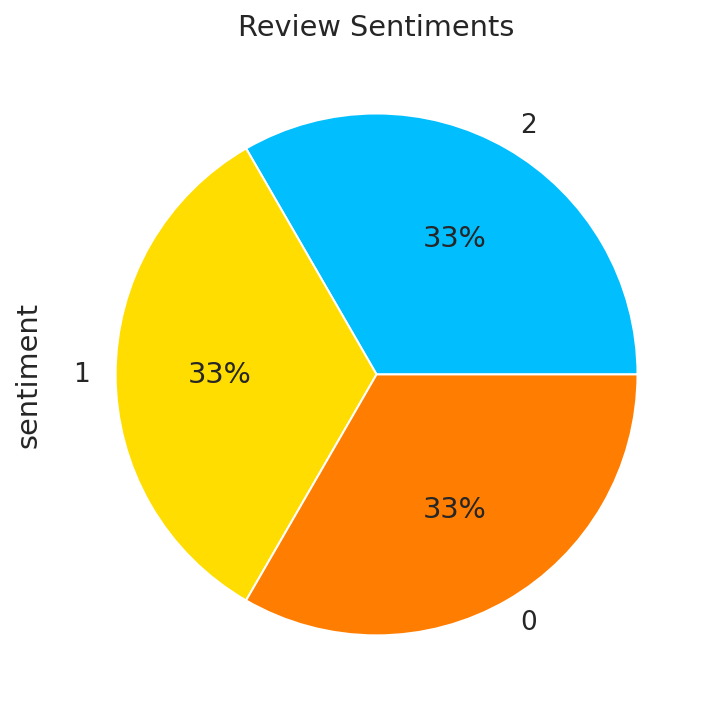

In [93]:
#plot the sentiment distribution
plt.figure(figsize=(6,6))
df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Review Sentiments');

In [94]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,B5lLAl-RsO6BakFE7nxUyw,cWPfwvb1ua66BXlxBexhQA,Y4OWm-XIXKBUkogYx7rh2w,1.0,1,0,0,"The owner, THE OWNER, is about as rude as they...",2016-01-24 00:24:53,0
1,8RE9AAgyAYxiIIduVIMsLg,sug_nWZjo0IY-n8dMF6Baw,cNNOcuykCG0yNDzevqBKIg,1.0,0,0,0,Unless you want to eat barely cooked cold seaf...,2018-12-01 03:49:40,0
2,i3OquLmo4cS-EHvzy3A5Fg,M6uDHCxhZybBdngFuBmrHg,T0NKethAB-FFR05EeZCzuA,1.0,0,1,0,It's been a couple years since I got a whopper...,2012-06-21 21:16:12,0
3,x6gZKbwEunbpTVoTyQpd-g,3FIan7CB37o7XpGnS_12Zg,1NjYVJHmGDGrfTuuuZJncA,1.0,0,0,0,On line ordering has no method of changing ord...,2017-09-12 13:34:08,0
4,cmRGAidUbW9aHs3Jm7dE5Q,W1Nde0RcP1-eoEpesZjb_g,3PekkCkOZD7Pe3Q4owP3Pg,1.0,4,1,0,I asked to get the sleeves of my nice wool coa...,2013-09-24 19:55:54,0
...,...,...,...,...,...,...,...,...,...,...
29995,n7nJzWURyuiUSvzNXpBpVg,kB-0ik8Xtw3kwuN4WM81yQ,hcFSc0OHgZJybnjQBrL_8Q,4.0,0,0,0,"As a noodle fan, it's good to go! The size per...",2017-08-01 20:18:17,2
29996,FYsXeILs2nbwq2HutkDNyw,3Uv0dGI2IXJb2OUj8R2GJA,eoJfl5vG7X87QhcKb0nt5Q,4.0,5,3,3,This place is the Disneyland of beer.\n\nYou w...,2017-01-12 02:50:34,2
29997,creE4zCXK7ZS0BihvVV9yg,6_OUuFht6DEC01zTU0bFrw,TEwzpsuLkAM6RZkUSApTHg,5.0,0,0,0,"Jason is a rare breed, an honest mechanic who ...",2017-09-05 21:12:27,2
29998,5RgrT8LArbmpZ1IedF_K1A,k4aO7Jy00yNbjl3YQ3KI-Q,DWGD9u3zqPTH8w4j5VUVsg,5.0,3,0,1,Dr Chamberlains team is terrific. I could not ...,2015-07-09 12:56:46,2


## Data Preprocessing

Here are the BERT requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*


In [95]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. uncased had better accuracy for our dataset.

Load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [96]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [188]:
sample_txt = "poor quality food. steak sandwich with mushrooms had mushrooms than steak on it. steak was stone cold. i asked for a fresh one and it was so so. i didn't finish it. my girlfriends salad was called a 'chopped salad' the lumps of lettuce were never chopped. barely any chicken in it either. poor experience"

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [189]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: poor quality food. steak sandwich with mushrooms had mushrooms than steak on it. steak was stone cold. i asked for a fresh one and it was so so. i didn't finish it. my girlfriends salad was called a 'chopped salad' the lumps of lettuce were never chopped. barely any chicken in it either. poor experience
   Tokens: ['poor', 'quality', 'food', '.', 'steak', 'sandwich', 'with', 'mushroom', '##s', 'had', 'mushroom', '##s', 'than', 'steak', 'on', 'it', '.', 'steak', 'was', 'stone', 'cold', '.', 'i', 'asked', 'for', 'a', 'fresh', 'one', 'and', 'it', 'was', 'so', 'so', '.', 'i', 'didn', "'", 't', 'finish', 'it', '.', 'my', 'girlfriend', '##s', 'salad', 'was', 'called', 'a', "'", 'ch', '##opped', 'salad', "'", 'the', 'lump', '##s', 'of', 'let', '##tu', '##ce', 'were', 'never', 'ch', '##opped', '.', 'barely', 'any', 'chicken', 'in', 'it', 'either', '.', 'poor', 'experience']
Token IDs: [2869, 3068, 2094, 119, 26704, 14327, 1114, 25590, 1116, 1125, 25590, 1116, 1190, 26704, 1113, 1122

### Special Tokens

`[SEP]` - marker for ending of a sentence


In [190]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [191]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [192]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [193]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [194]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [195]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2869,  3068,  2094,   119, 26704, 14327,  1114, 25590,  1116,
         1125, 25590,  1116,  1190, 26704,  1113,  1122,   119, 26704,  1108,
         2576,  2504,   119,   178,  1455,  1111,   170,  4489,  1141,  1105,
         1122,   102])

The attention mask has the same length:

In [196]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

We can inverse the tokenization to have a look at the special tokens:

In [197]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'poor',
 'quality',
 'food',
 '.',
 'steak',
 'sandwich',
 'with',
 'mushroom',
 '##s',
 'had',
 'mushroom',
 '##s',
 'than',
 'steak',
 'on',
 'it',
 '.',
 'steak',
 'was',
 'stone',
 'cold',
 '.',
 'i',
 'asked',
 'for',
 'a',
 'fresh',
 'one',
 'and',
 'it',
 '[SEP]']

### Choosing Sequence Length

BERT works with fixed-length sequences.

In [198]:
#cutting the number of dataset into half
#df_h = df.groupby('sentiment').apply(lambda df: df.sample(10000))

In [199]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

AttributeError: 'DataFrame' object has no attribute 'text'

and plot the distribution:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


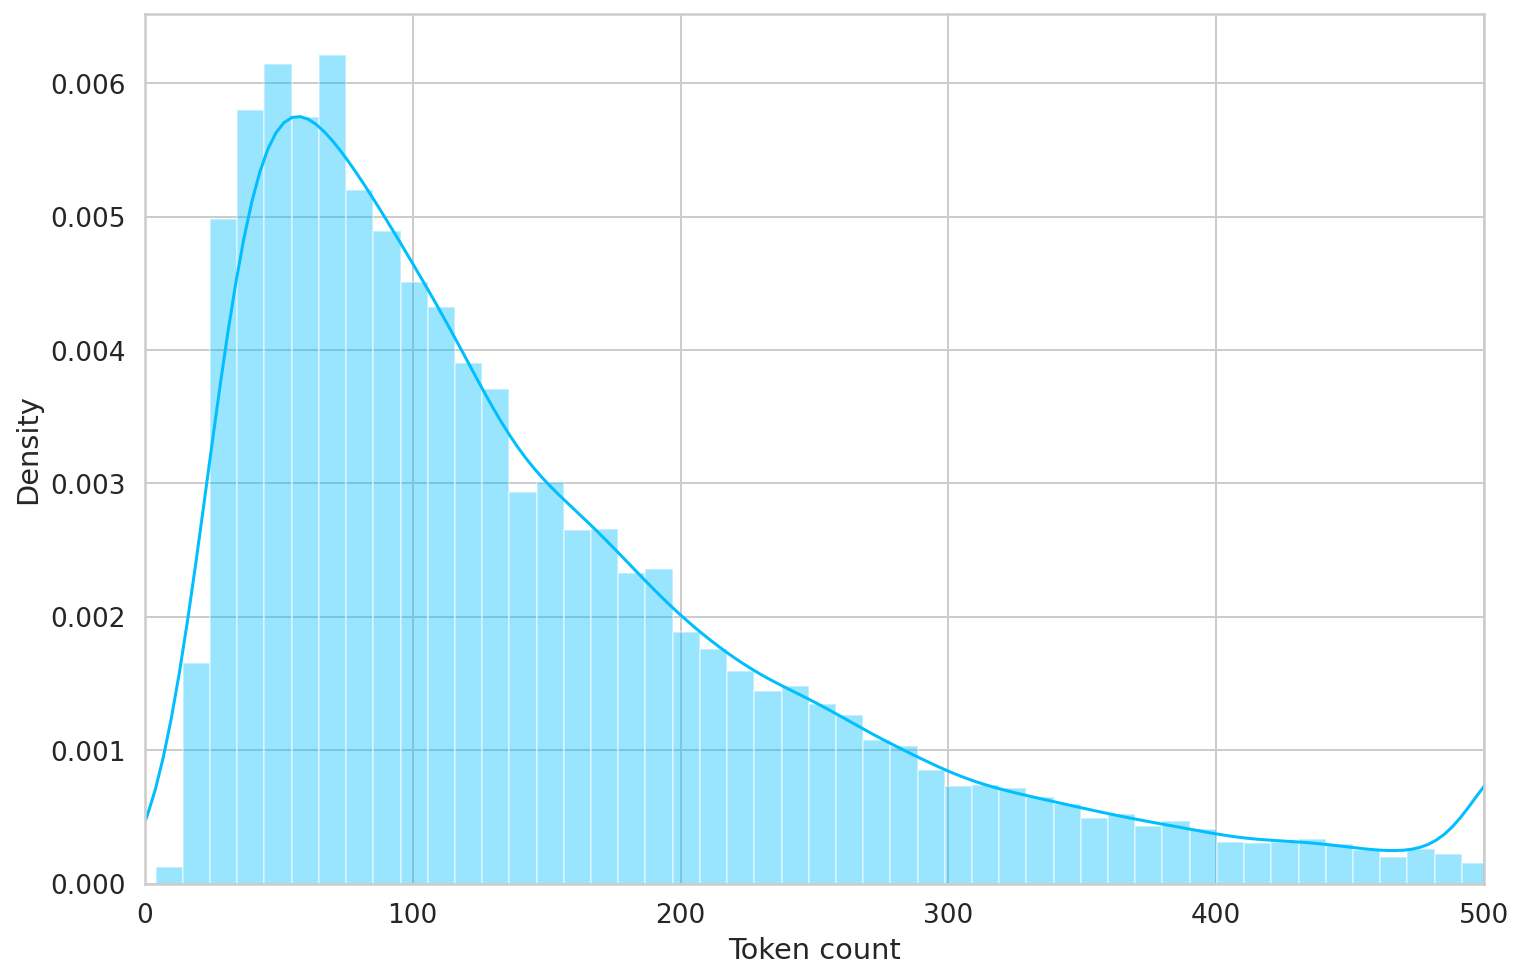

In [109]:
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 300 tokens, so we'll choose a maximum length of 300.

In [200]:
MAX_LEN = 300

We have all building blocks required to create a PyTorch dataset.

In [111]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [112]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [113]:
df_train.shape, df_val.shape, df_test.shape

((24000, 10), (3000, 10), (3000, 10))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [114]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [115]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [116]:
data = next(iter(train_data_loader))
data.keys()

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [117]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 300])
torch.Size([16, 300])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [118]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [119]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [120]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). 768 is the number of hidden units in the feedforward-networks.

In [121]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT.

In [122]:
pooled_output.shape

torch.Size([1, 768])

We can create a classifier that uses the BERT model:

In [123]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Create an instance and move it to the GPU:

In [124]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [125]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 300])
torch.Size([16, 300])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [126]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4853, 0.1905, 0.3242],
        [0.4315, 0.1371, 0.4315],
        [0.4749, 0.1266, 0.3986],
        [0.5158, 0.0803, 0.4039],
        [0.4294, 0.1582, 0.4123],
        [0.4228, 0.1590, 0.4182],
        [0.4304, 0.1336, 0.4360],
        [0.3812, 0.1837, 0.4351],
        [0.4268, 0.0864, 0.4868],
        [0.5047, 0.1351, 0.3602],
        [0.4709, 0.1761, 0.3530],
        [0.3716, 0.1410, 0.4874],
        [0.5433, 0.1136, 0.3431],
        [0.3210, 0.2402, 0.4388],
        [0.3470, 0.0705, 0.5825],
        [0.6322, 0.1083, 0.2594]], grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [127]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Helper function for training our model for one epoch:

In [128]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [129]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Training vs validation accuracy:

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Can load the trained model below:

In [134]:
#!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state_yelp.bin'))
# model = model.to(device)
#torch.save(model.state_dict(), 'best_model_state_yelp.bin')

<All keys matched successfully>

## Evaluation

Calculate the accuracy on the test data:

In [135]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.81

We'll define a helper function to get the predictions from our model:

In [136]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [137]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Let's have a look at the classification report

In [138]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.85      0.83      0.84      1006
     neutral       0.72      0.73      0.72       997
    positive       0.87      0.87      0.87       997

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



Looks like it is hard to classify neutral (3 stars) reviews.

Confusion matrix:

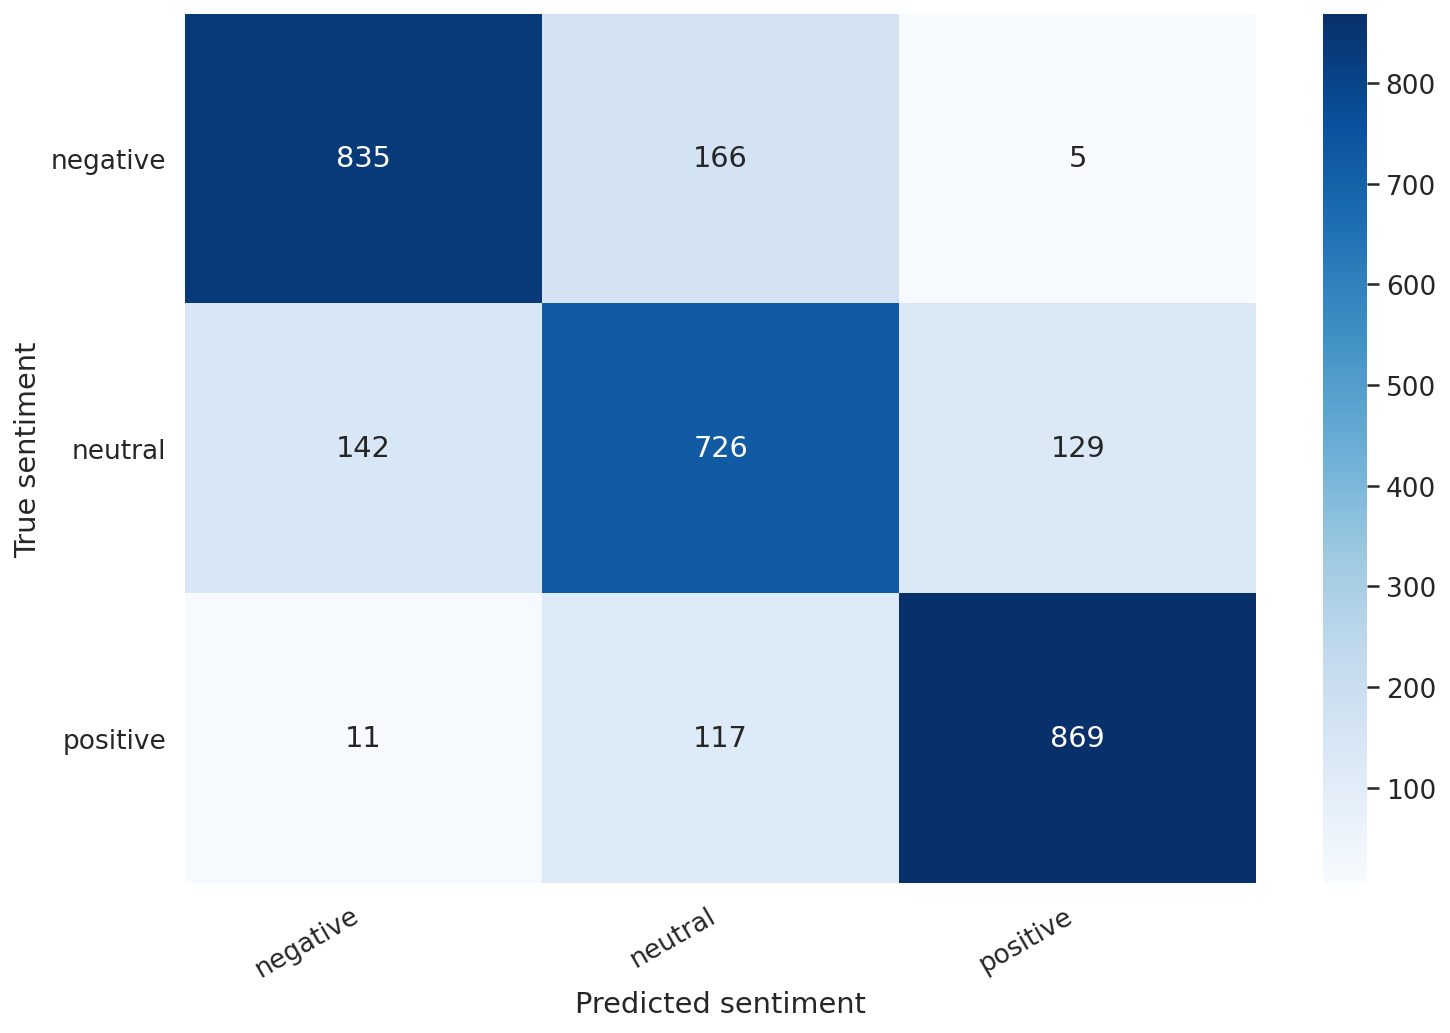

In [214]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

In [143]:
idx = 8

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [144]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

The worst and most disgusting food ever. The crispy noodles were
smothered with extremely sweet yuck sauce. Pad Thai tasted like card
Baird. And they are expensive. This I wouldn't eat if someone paid me
to eat. Save your money and your taste buds. Stay away!

True sentiment: negative


Now we can look at the confidence of each sentiment of our model:

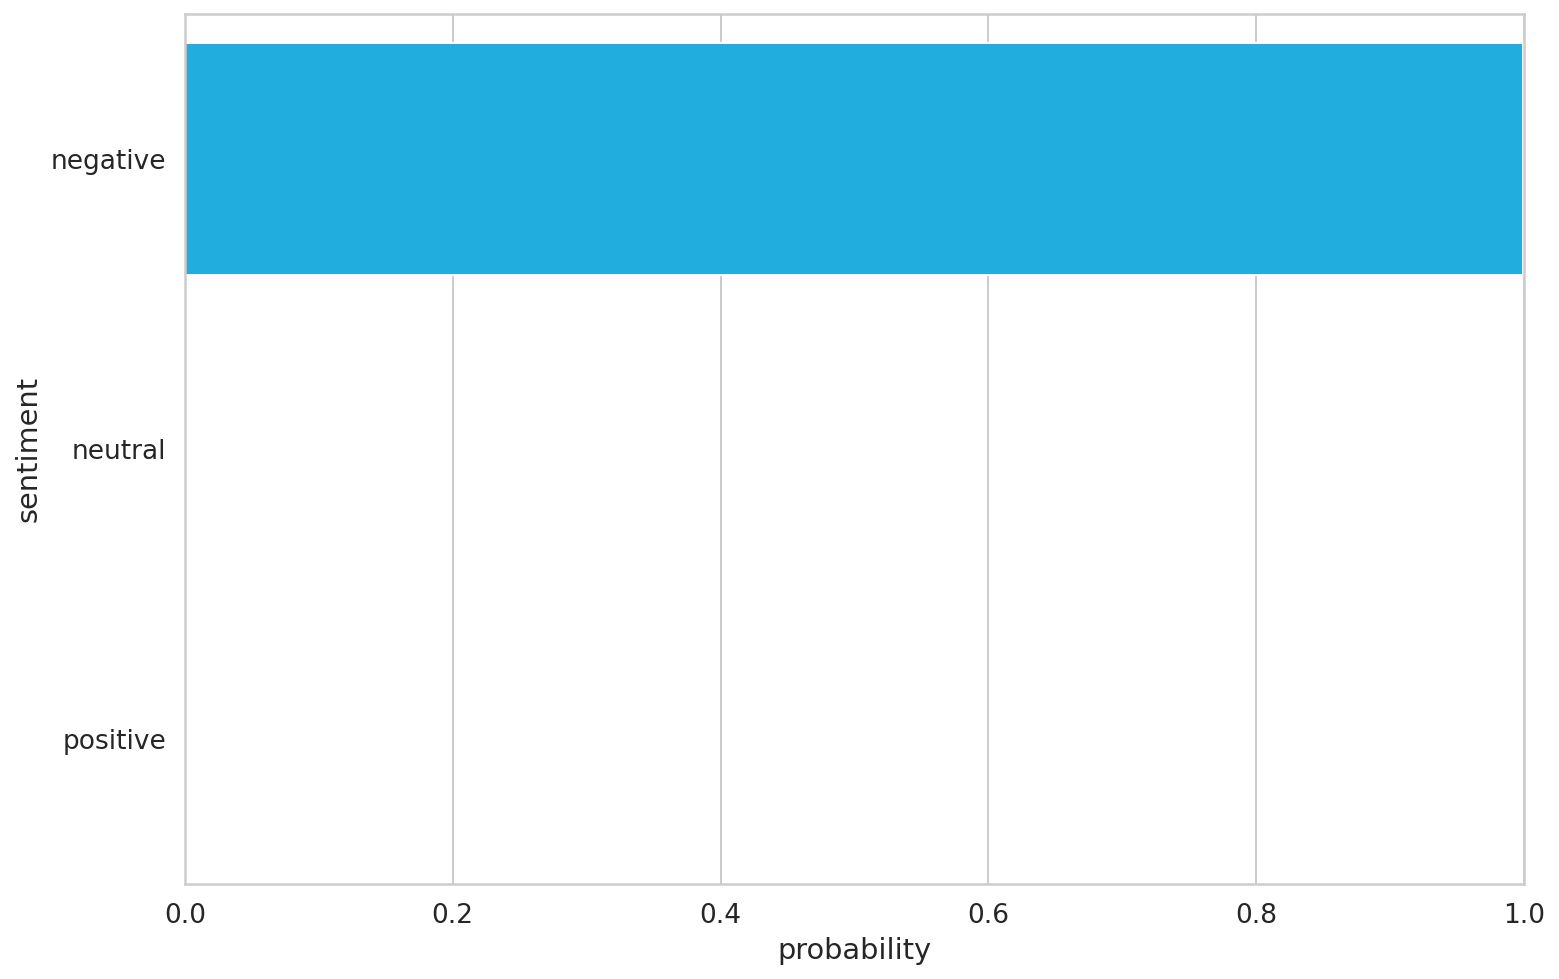

In [145]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Predict the sentiment of some raw text:

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    30000 non-null  object 
 1   user_id      30000 non-null  object 
 2   business_id  30000 non-null  object 
 3   stars        30000 non-null  float64
 4   useful       30000 non-null  int64  
 5   funny        30000 non-null  int64  
 6   cool         30000 non-null  int64  
 7   text         30000 non-null  object 
 8   date         30000 non-null  object 
 9   sentiment    30000 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 3.8+ MB


In [245]:
df_output = df.copy()

We have to use the tokenizer to encode the text:

In [243]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [244]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: i am not overwhelmed. been here twice and found the food to be just ok. had the strip steak (38 $) on my most recent visit. good flavor but the meat was tough. my daughter loves the ambiance so we will be back.
Sentiment  : neutral


In [267]:
for i in range(70):
    review_text = df_output.review8[i]

    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    df_output.review8[i] = class_names[prediction]

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [300]:
df_test = df_output.copy()

In [282]:
df_style = df_output.style.applymap(lambda x: 'background-color : red' if x == 'negative' else '')

AttributeError: 'Styler' object has no attribute 'style'

In [ ]:
def apply_formatting(col):
    if col.name == 'positive':
        return ['background-color: skyblue' if c > 50 else '' for c in col.values]
    if col.name == 'b':
        return ['background-color: green' if c > 10 else '' for c in col.values]
    if col.name == 'c':
        return ['background-color: blue' if c > 30 else '' for c in col.values]

data = pd.DataFrame(
    np.random.randint(0, 100, 30).reshape(10, 3), columns=['a', 'b', 'c'])

data.style.apply(apply_formatting) 

In [358]:
df

,business_id,gold_summ,gen_summ,review1,review2,review3,review4,review5,review6,review7,review8
0,NWh0MGOPFAy7yElepNtIxg,The beauty of this place is that it has high q...,Love this place! I've been here three times no...,chopshop is the greatest versatile spot becaus...,i've recently found this charming new restaura...,negative,"i love this place, everything tastes good and ...",perfect! real food. quality choices. fast. gre...,loved everything we ordered. we got a beet sal...,great spot. went there tonight for the first t...,had to go out to eat after eating a salad here...
1,Nbhpg1TbDwtMuyh9ZIPceA,This place is a small family owned Thai restau...,This place is fantastic! The food was deliciou...,it was okay but we were expecting more based o...,awesome little thai place! the food is amazing...,positive,i stumbled across this place by accident when ...,"we got the thai fried rice, egg rolls and many...",this place was awful. i ordered tamarind duck ...,"a little scary outside, inside a real gem. fam...",i had panang curry and j had thai spicy noddle...
2,Ohu6w8_RYE5KdHEWGdBjXQ,The Mesa Arts Center is a clean modern place t...,This is the second time I've been here and bot...,went to see our favorite artist last night (gr...,"great place to see some interesting art, but o...",positive,my favorite theater in phoenix! relatively new...,"no lie, i'd pay $20 more to see a concert here...",horrible seating very very disappointed at the...,been coming here for years. many shows here an...,mac is a great venue. matthew morrison was kin...
3,OkC86YtZ0Nm19my5F4GGrQ,Tartine is a nice place with a combination of ...,The food here is a little pricey but worth eve...,love the atmosphere of this place. it tends to...,amazing. excellent choice for lunch. baked bri...,positive,first time going here and i was impressed. ver...,my fiance and i really enjoyed eating here for...,i'm not sure why i was so hard with my first r...,i am not overwhelmed. been here twice and foun...,"the best combination of atmosphere, food, and ..."
4,Q2ZNaN3p8s_-XXjBWyY2qA,The service at Ruth's steakhouse is serviceabl...,Best meal I've ever had in a long time. The st...,first time at this restaurant. from the greeti...,it is great but compared to other ruth's chris...,positive,the best filet minion in toronto. super smooth...,had a top sirloin steak today with mushroom an...,got the filet with a side of mac and cheese. s...,if you blink you might miss this gem across th...,4 stars for the amazingly soft and tender stea...
...,...,...,...,...,...,...,...,...,...,...,...
65,ypSAad4wGe3Uh0N6dgVxaw,"This is a great Porche dealer, highly recommen...",These guys are the best I've ever had in my li...,excellent dealership that prides itself on ser...,mgr dave and salesman kevin campbell made the ...,positive,the salesman ian was too good to take my porsc...,just bought a porsche panamera s and absolutel...,family has purchased a total of 3 purchases wi...,the best customer service ever! my son wanted ...,kevin campbell exceeded my expectations! his k...
66,zHAR8MmCbjrkNnLGm1ozEQ,"The food here is served fast and fresh, but it...","It's a Mexican restaurant, but the food is del...",food was good but a little expensive for a div...,goes to show that just because a restaurant ha...,positive,ordered through uber eats. got 2 chicken enchi...,this place is very delicious. i've had the chi...,came here for the steak fries after reading th...,the wife and i moved to area from san diego. h...,rivas mexican grill sin duda alguna lo recomie...
67,zJzkL4VHHksVVGepR1IAGw,The food at this restaurant is generally well-...,The food here is amazing! Service was attentiv...,went to have brunch for mother's day and found...,my boyfriend loved this restaurant although we...,neutral,food here is really good however i will say th...,"i do like this place, the food is great, but t...",the food was delicious! the wait staff really ...,"sweet, spicy and get outta here delicious <UNK...",halifax do

In [311]:
df_test = df_test.applymap(lambda x: 0 if x == 'negative' else x)

#condition = [(df_test['stars']>=4), (df_pre['stars']<=2), (df_pre['stars']==3)]
#values = ['positive','negative','neutral']
#df_pre['sentiment']=np.select(condition, values)
#df_pre

In [353]:
avg = []
for i in range(70):
    avg.append(sum(df_test.iloc[i,3:11])/8)
    
print(avg)


df_test.insert(loc=3, column='avergage', value=avg)

[1.5, 1.625, 1.25, 1.625, 1.625, 1.0, 1.75, 1.625, 1.125, 1.125, 1.75, 1.625, 0.75, 1.625, 1.375, 1.375, 1.625, 1.875, 1.875, 1.375, 0.75, 1.25, 1.125, 1.125, 1.0, 1.875, 1.25, 2.0, 0.875, 1.625, 1.25, 1.375, 2.0, 1.625, 1.0, 1.625, 0.875, 1.5, 1.375, 1.75, 2.0, 1.875, 1.125, 1.625, 1.75, 0.875, 1.25, 1.875, 1.5, 0.25, 1.75, 1.125, 2.0, 1.75, 1.625, 1.25, 1.375, 1.375, 2.0, 1.5, 1.75, 2.0, 0.5, 1.5, 1.625, 1.75, 1.0, 1.375, 1.5, 1.625]


In [401]:
import seaborn as sns 
  
# Declaring the cm variable by the  
# color palette from seaborn 
cm = sns.light_palette("#6698FF", as_cmap=True) 
  
# Visualizing the DataFrame with set precision 
print("\nModified Stlying DataFrame:") 
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))

df_test.style.background_gradient(cmap=cm).set_precision(2).highlight_null('red').highlight_min(axis=0, color='#F9966B').highlight_max(axis=0, color='blue')


Modified Stlying DataFrame:


,business_id,gold_summ,gen_summ,avergage,review1,review2,review3,review4,review5,review6,review7,review8
0,NWh0MGOPFAy7yElepNtIxg,2,2,1.50,2,2,0,2,2,2,2,0
1,Nbhpg1TbDwtMuyh9ZIPceA,2,2,1.62,1,2,2,2,2,0,2,2
2,Ohu6w8_RYE5KdHEWGdBjXQ,2,2,1.25,1,1,2,2,1,0,2,1
3,OkC86YtZ0Nm19my5F4GGrQ,2,2,1.62,1,2,2,2,2,1,1,2
4,Q2ZNaN3p8s_-XXjBWyY2qA,1,2,1.62,2,1,2,1,2,1,2,2
5,QNfh79NwsNnl-AngRhg2ww,0,0,1.00,1,2,0,1,0,0,2,2
6,QUs_7nqxo0xYE-KazHlx5A,2,2,1.75,1,2,2,2,2,2,2,1
7,Q_BDMqf4tLrS_44g38dqXQ,2,2,1.62,2,1,1,2,2,1,2,2
8,REM8BezFuK4MQ6j2k1I7-Q,1,2,1.12,1,2,2,2,1,1,0,0
9,RRpHuoXpxcuLk4LdB_YrOg,1,2,1.12,0,2,2,2,1,0,2,0


In [363]:
import numpy as np

sum=0
for i in range (70):
    sum += np.square(df_test.gen_summ[i]-df_test.avergage[i])
    
print(sum/70)

0.3375


In [364]:
sum=0
for i in range (70):
    sum += np.square(df_test.gold_summ[i]-df_test.avergage[i])
    
print(sum/70)

0.2125


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)